The following example notebook implements standard diffusion
with a simple CNN model to generate realistic MNIST digits.

This is a modified implementation of `minDiffusion`
which implements [DDPM](https://arxiv.org/abs/2006.11239).

To run this example notebook,
install requirements as in `requirements.txt` (for example, `pip install -r requirements.txt`).
You may also wish to follow system-dependent PyTorch instructions
[here](https://pytorch.org/) to install accelerated
versions of PyTorch, but note they are not needed
(I am testing this on my laptop).

If you do use accelerated hardware, make sure that your code
is still compatible with CPU-only installs.

First, let's create a folder to store example images:

In [1]:
!mkdir -p contents

In [2]:
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid

In [3]:
# set seed
np.random.seed(12042000)

The following function creates a DDPM training schedule for use when evaluating
and training the diffusion model:

In [4]:
def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}


Next, we create a simple 2D convolutional neural network. This network
is essentially going to try to estimate the diffusion process --- we
can then use this network to generate realistic images.

First, we create a single CNN block which we will stack to create the
full network. We use `LayerNorm` for stable training and no batch dependence.

In [5]:
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm((out_channels, *expected_shape)),
            act()
        )

    def forward(self, x):
        return self.net(x)

We then create the full CNN model, which is a stack of these blocks
according to the `n_hidden` tuple, which specifies the number of
channels at each hidden layer.

In [6]:
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)

        return embed

Next, we define the actual diffusion model, which specifies the training
schedule, takes an arbitrary model for estimating the
diffusion process (such as the CNN above),
and computes the corresponding loss (as well as generating samples).

In [7]:
class DDPM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_schedules(betas[0], betas[1], n_T)

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Algorithm 18.1 in Prince"""

        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting

        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        # This is the z_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(eps, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                # Last line of loop:
                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            # (We don't add noise at the final step - i.e., the last line of the algorithm)

        return z_t

We will run this on MNIST. We perform some basic preprocessing, and set up the data loader:

In [8]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
train_dataset = MNIST("./data", train=True, download=True, transform=tf)
test_dataset = MNIST("./data", train=False, download=True, transform=tf)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, drop_last=True)


We create our model with a given choice of hidden layers and activation function. We also choose a learning rate.

In [9]:
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
# For testing: (16, 32, 32, 16)
# For more capacity (for example): (64, 128, 256, 128, 64)
ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

We could set up a GPU if we have one, which is done below.

Here, we use HuggingFace's `accelerate` library, which abstracts away all the `.to(device)` calls for us.
This lets us focus on the model itself rather than data movement.
It also does a few other tricks to speed up calculations.

PyTorch Lightning, which we discussed during the course, is another option that also handles a lot more, but is a bit heavyweight.
`accelerate` is a simpler option closer to raw PyTorch.
However, if you prefer, you could choose to use Lightning for the coursework!

In [10]:
accelerator = Accelerator()

# We wrap our model, optimizer, and dataloaders with `accelerator.prepare`,
# which lets HuggingFace's Accelerate handle the device placement and gradient accumulation.
ddpm, optim, train_dataloader, test_dataloader = accelerator.prepare(ddpm, optim, train_dataloader, test_dataloader)

First, let's just make sure this works:

In [11]:
for x, _ in test_dataloader:
    break

with torch.no_grad():
    ddpm(x)

Now, let's train it. You can exit early by interrupting the kernel. Images
are saved to the `contents` folder.

In [12]:
n_epoch = 100
train_losses = []
val_losses = []
avg_train_losses_per_epoch = []
avg_val_losses_per_epoch = []

for epoch in range(n_epoch):
    # training
    ddpm.train()
    pbar = tqdm(train_dataloader)
    temp_train_losses = []

    for x, _ in pbar:
        optim.zero_grad()
        train_loss = ddpm(x)
        train_loss.backward()
        optim.step()

        temp_train_losses.append(train_loss.item())
        pbar.set_description(f"Epoch {epoch} - Train Loss: {np.mean(temp_train_losses[-100:]):.3g}")

    
    avg_train_loss = np.mean(temp_train_losses)
    avg_train_losses_per_epoch.append(avg_train_loss)
        
    # validation
    ddpm.eval()

    temp_val_losses = []
    with torch.no_grad():
        for x, _ in test_dataloader:
            val_loss = ddpm(x)
            temp_val_losses.append(val_loss.item())
        
        avg_val_loss = np.mean(temp_val_losses)
        avg_val_losses_per_epoch.append(avg_val_loss)
        print(f"Epoch {epoch} - Val Loss: {avg_val_loss:.3g}")
        
    # generate samples
    with torch.no_grad():
        xh = ddpm.sample(16, (1, 28, 28), accelerator.device)  # Can get device explicitly with `accelerator.device`
        grid = make_grid(xh, nrow=4)

        # Save samples to `./contents` directory
        save_image(grid, f"./contents/ddpm_sample_{epoch:04d}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_mnist.pth")


Epoch 0 - Train Loss: 0.0366: 100%|██████████| 468/468 [00:20<00:00, 22.72it/s]


Epoch 0 - Val Loss: 0.0348


Epoch 1 - Train Loss: 0.0238: 100%|██████████| 468/468 [00:16<00:00, 27.83it/s]


Epoch 1 - Val Loss: 0.0231


Epoch 2 - Train Loss: 0.0197: 100%|██████████| 468/468 [00:16<00:00, 27.75it/s]


Epoch 2 - Val Loss: 0.0197


Epoch 3 - Train Loss: 0.0173: 100%|██████████| 468/468 [00:17<00:00, 27.11it/s]


Epoch 3 - Val Loss: 0.017


Epoch 4 - Train Loss: 0.0158: 100%|██████████| 468/468 [00:16<00:00, 27.71it/s]


Epoch 4 - Val Loss: 0.015


Epoch 5 - Train Loss: 0.0139: 100%|██████████| 468/468 [00:16<00:00, 27.84it/s]


Epoch 5 - Val Loss: 0.0137


Epoch 6 - Train Loss: 0.0133: 100%|██████████| 468/468 [00:17<00:00, 27.49it/s]


Epoch 6 - Val Loss: 0.0131


Epoch 7 - Train Loss: 0.0128: 100%|██████████| 468/468 [00:16<00:00, 27.84it/s]


Epoch 7 - Val Loss: 0.0131


Epoch 8 - Train Loss: 0.0123: 100%|██████████| 468/468 [00:16<00:00, 27.83it/s]


Epoch 8 - Val Loss: 0.0119


Epoch 9 - Train Loss: 0.0121: 100%|██████████| 468/468 [00:17<00:00, 27.29it/s]


Epoch 9 - Val Loss: 0.0114


Epoch 10 - Train Loss: 0.0113: 100%|██████████| 468/468 [00:16<00:00, 27.87it/s]


Epoch 10 - Val Loss: 0.0117


Epoch 11 - Train Loss: 0.0114: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch 11 - Val Loss: 0.0114


Epoch 12 - Train Loss: 0.011: 100%|██████████| 468/468 [00:17<00:00, 27.38it/s] 


Epoch 12 - Val Loss: 0.0112


Epoch 13 - Train Loss: 0.0115: 100%|██████████| 468/468 [00:17<00:00, 27.51it/s]


Epoch 13 - Val Loss: 0.011


Epoch 14 - Train Loss: 0.0108: 100%|██████████| 468/468 [00:16<00:00, 27.72it/s]


Epoch 14 - Val Loss: 0.0107


Epoch 15 - Train Loss: 0.0106: 100%|██████████| 468/468 [00:17<00:00, 27.37it/s]


Epoch 15 - Val Loss: 0.011


Epoch 16 - Train Loss: 0.0107: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch 16 - Val Loss: 0.0108


Epoch 17 - Train Loss: 0.0106: 100%|██████████| 468/468 [00:16<00:00, 27.89it/s]


Epoch 17 - Val Loss: 0.0106


Epoch 18 - Train Loss: 0.0105: 100%|██████████| 468/468 [00:16<00:00, 27.56it/s]


Epoch 18 - Val Loss: 0.0102


Epoch 19 - Train Loss: 0.0103: 100%|██████████| 468/468 [00:16<00:00, 27.54it/s]


Epoch 19 - Val Loss: 0.0102


Epoch 20 - Train Loss: 0.0104: 100%|██████████| 468/468 [00:16<00:00, 27.82it/s]


Epoch 20 - Val Loss: 0.01


Epoch 21 - Train Loss: 0.0104: 100%|██████████| 468/468 [00:17<00:00, 27.38it/s] 


Epoch 21 - Val Loss: 0.0101


Epoch 22 - Train Loss: 0.0105: 100%|██████████| 468/468 [00:16<00:00, 27.71it/s]


Epoch 22 - Val Loss: 0.0101


Epoch 23 - Train Loss: 0.0103: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s] 


Epoch 23 - Val Loss: 0.00986


Epoch 24 - Train Loss: 0.0101: 100%|██████████| 468/468 [00:16<00:00, 27.54it/s] 


Epoch 24 - Val Loss: 0.00974


Epoch 25 - Train Loss: 0.0101: 100%|██████████| 468/468 [00:17<00:00, 27.47it/s] 


Epoch 25 - Val Loss: 0.00971


Epoch 26 - Train Loss: 0.00969: 100%|██████████| 468/468 [00:16<00:00, 27.68it/s]


Epoch 26 - Val Loss: 0.0104


Epoch 27 - Train Loss: 0.00909: 100%|██████████| 468/468 [00:16<00:00, 27.76it/s]


Epoch 27 - Val Loss: 0.00958


Epoch 28 - Train Loss: 0.00942: 100%|██████████| 468/468 [00:17<00:00, 27.28it/s]


Epoch 28 - Val Loss: 0.00944


Epoch 29 - Train Loss: 0.00915: 100%|██████████| 468/468 [05:16<00:00,  1.48it/s]  


Epoch 29 - Val Loss: 0.00908


Epoch 30 - Train Loss: 0.00953: 100%|██████████| 468/468 [00:16<00:00, 27.74it/s]


Epoch 30 - Val Loss: 0.00891


Epoch 31 - Train Loss: 0.00895: 100%|██████████| 468/468 [05:16<00:00,  1.48it/s]


Epoch 31 - Val Loss: 0.00951


Epoch 32 - Train Loss: 0.00877: 100%|██████████| 468/468 [00:17<00:00, 27.28it/s]


Epoch 32 - Val Loss: 0.00911


Epoch 33 - Train Loss: 0.009: 100%|██████████| 468/468 [00:16<00:00, 27.95it/s]  


Epoch 33 - Val Loss: 0.00929


Epoch 34 - Train Loss: 0.00902: 100%|██████████| 468/468 [00:19<00:00, 24.25it/s]


Epoch 34 - Val Loss: 0.00874


Epoch 35 - Train Loss: 0.0089: 100%|██████████| 468/468 [00:17<00:00, 26.42it/s] 


Epoch 35 - Val Loss: 0.00905


Epoch 36 - Train Loss: 0.00883: 100%|██████████| 468/468 [00:17<00:00, 27.08it/s]


Epoch 36 - Val Loss: 0.00892


Epoch 37 - Train Loss: 0.0086: 100%|██████████| 468/468 [00:16<00:00, 27.98it/s] 


Epoch 37 - Val Loss: 0.00868


Epoch 38 - Train Loss: 0.00868: 100%|██████████| 468/468 [00:16<00:00, 27.92it/s]


Epoch 38 - Val Loss: 0.00888


Epoch 39 - Train Loss: 0.00872: 100%|██████████| 468/468 [00:17<00:00, 26.95it/s]


Epoch 39 - Val Loss: 0.00877


Epoch 40 - Train Loss: 0.00884: 100%|██████████| 468/468 [00:18<00:00, 25.66it/s]


Epoch 40 - Val Loss: 0.00832


Epoch 41 - Train Loss: 0.00856: 100%|██████████| 468/468 [00:17<00:00, 27.35it/s]


Epoch 41 - Val Loss: 0.00852


Epoch 42 - Train Loss: 0.00848: 100%|██████████| 468/468 [00:17<00:00, 26.68it/s]


Epoch 42 - Val Loss: 0.00845


Epoch 43 - Train Loss: 0.00881: 100%|██████████| 468/468 [00:17<00:00, 27.20it/s]


Epoch 43 - Val Loss: 0.00881


Epoch 44 - Train Loss: 0.00875: 100%|██████████| 468/468 [00:16<00:00, 27.76it/s]


Epoch 44 - Val Loss: 0.00878


Epoch 45 - Train Loss: 0.0087: 100%|██████████| 468/468 [00:17<00:00, 27.43it/s] 


Epoch 45 - Val Loss: 0.00866


Epoch 46 - Train Loss: 0.00875: 100%|██████████| 468/468 [00:17<00:00, 27.10it/s]


Epoch 46 - Val Loss: 0.00848


Epoch 47 - Train Loss: 0.0088: 100%|██████████| 468/468 [00:17<00:00, 27.43it/s] 


Epoch 47 - Val Loss: 0.00861


Epoch 48 - Train Loss: 0.00868: 100%|██████████| 468/468 [00:16<00:00, 27.58it/s]


Epoch 48 - Val Loss: 0.00891


Epoch 49 - Train Loss: 0.00859: 100%|██████████| 468/468 [00:18<00:00, 25.88it/s]


Epoch 49 - Val Loss: 0.00849


Epoch 50 - Train Loss: 0.00836: 100%|██████████| 468/468 [00:18<00:00, 24.90it/s]


Epoch 50 - Val Loss: 0.00863


Epoch 51 - Train Loss: 0.00837: 100%|██████████| 468/468 [00:16<00:00, 27.74it/s]


Epoch 51 - Val Loss: 0.00827


Epoch 52 - Train Loss: 0.00869: 100%|██████████| 468/468 [00:17<00:00, 27.48it/s]


Epoch 52 - Val Loss: 0.00872


Epoch 53 - Train Loss: 0.0085: 100%|██████████| 468/468 [00:16<00:00, 27.63it/s] 


Epoch 53 - Val Loss: 0.0084


Epoch 54 - Train Loss: 0.00831: 100%|██████████| 468/468 [00:17<00:00, 27.40it/s]


Epoch 54 - Val Loss: 0.00858


Epoch 55 - Train Loss: 0.00859: 100%|██████████| 468/468 [00:16<00:00, 27.65it/s]


Epoch 55 - Val Loss: 0.00832


Epoch 56 - Train Loss: 0.0086: 100%|██████████| 468/468 [00:16<00:00, 27.60it/s] 


Epoch 56 - Val Loss: 0.00869


Epoch 57 - Train Loss: 0.00837: 100%|██████████| 468/468 [00:16<00:00, 27.60it/s]


Epoch 57 - Val Loss: 0.00828


Epoch 58 - Train Loss: 0.00839: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch 58 - Val Loss: 0.00849


Epoch 59 - Train Loss: 0.00844: 100%|██████████| 468/468 [00:16<00:00, 27.74it/s]


Epoch 59 - Val Loss: 0.00824


Epoch 60 - Train Loss: 0.00821: 100%|██████████| 468/468 [00:17<00:00, 27.32it/s]


Epoch 60 - Val Loss: 0.00844


Epoch 61 - Train Loss: 0.00815: 100%|██████████| 468/468 [00:17<00:00, 27.45it/s]


Epoch 61 - Val Loss: 0.00841


Epoch 62 - Train Loss: 0.0086: 100%|██████████| 468/468 [00:16<00:00, 27.66it/s] 


Epoch 62 - Val Loss: 0.00869


Epoch 63 - Train Loss: 0.00817: 100%|██████████| 468/468 [00:17<00:00, 27.47it/s]


Epoch 63 - Val Loss: 0.00825


Epoch 64 - Train Loss: 0.00842: 100%|██████████| 468/468 [00:16<00:00, 27.81it/s]


Epoch 64 - Val Loss: 0.00849


Epoch 65 - Train Loss: 0.00838: 100%|██████████| 468/468 [00:16<00:00, 27.65it/s]


Epoch 65 - Val Loss: 0.00872


Epoch 66 - Train Loss: 0.00861: 100%|██████████| 468/468 [00:17<00:00, 27.43it/s]


Epoch 66 - Val Loss: 0.00827


Epoch 67 - Train Loss: 0.00835: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch 67 - Val Loss: 0.00828


Epoch 68 - Train Loss: 0.00826: 100%|██████████| 468/468 [00:16<00:00, 27.61it/s]


Epoch 68 - Val Loss: 0.00837


Epoch 69 - Train Loss: 0.00867: 100%|██████████| 468/468 [00:16<00:00, 27.62it/s]


Epoch 69 - Val Loss: 0.0084


Epoch 70 - Train Loss: 0.00834: 100%|██████████| 468/468 [00:16<00:00, 27.65it/s]


Epoch 70 - Val Loss: 0.00848


Epoch 71 - Train Loss: 0.00872: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch 71 - Val Loss: 0.00815


Epoch 72 - Train Loss: 0.00813: 100%|██████████| 468/468 [00:16<00:00, 27.71it/s]


Epoch 72 - Val Loss: 0.0079


Epoch 73 - Train Loss: 0.00813: 100%|██████████| 468/468 [00:16<00:00, 27.73it/s]


Epoch 73 - Val Loss: 0.00843


Epoch 74 - Train Loss: 0.00846: 100%|██████████| 468/468 [00:17<00:00, 26.99it/s]


Epoch 74 - Val Loss: 0.00816


Epoch 75 - Train Loss: 0.00814: 100%|██████████| 468/468 [00:17<00:00, 27.02it/s]


Epoch 75 - Val Loss: 0.008


Epoch 76 - Train Loss: 0.00836: 100%|██████████| 468/468 [00:17<00:00, 27.08it/s]


Epoch 76 - Val Loss: 0.00833


Epoch 77 - Train Loss: 0.00824: 100%|██████████| 468/468 [00:16<00:00, 27.71it/s]


Epoch 77 - Val Loss: 0.00851


Epoch 78 - Train Loss: 0.00857: 100%|██████████| 468/468 [02:35<00:00,  3.01it/s] 


Epoch 78 - Val Loss: 0.00846


Epoch 79 - Train Loss: 0.00803: 100%|██████████| 468/468 [00:17<00:00, 26.87it/s]


Epoch 79 - Val Loss: 0.00787


Epoch 80 - Train Loss: 0.00848: 100%|██████████| 468/468 [00:17<00:00, 26.59it/s]


Epoch 80 - Val Loss: 0.00802


Epoch 81 - Train Loss: 0.00804: 100%|██████████| 468/468 [00:17<00:00, 26.56it/s]


Epoch 81 - Val Loss: 0.00819


Epoch 82 - Train Loss: 0.00784: 100%|██████████| 468/468 [00:17<00:00, 26.41it/s]


Epoch 82 - Val Loss: 0.00856


Epoch 83 - Train Loss: 0.00843: 100%|██████████| 468/468 [00:17<00:00, 26.05it/s]


Epoch 83 - Val Loss: 0.00826


Epoch 84 - Train Loss: 0.0082: 100%|██████████| 468/468 [00:17<00:00, 26.32it/s] 


Epoch 84 - Val Loss: 0.00809


Epoch 85 - Train Loss: 0.00826: 100%|██████████| 468/468 [00:17<00:00, 26.83it/s]


Epoch 85 - Val Loss: 0.00819


Epoch 86 - Train Loss: 0.00812: 100%|██████████| 468/468 [00:18<00:00, 25.71it/s]


Epoch 86 - Val Loss: 0.00792


Epoch 87 - Train Loss: 0.00836: 100%|██████████| 468/468 [00:17<00:00, 26.57it/s]


Epoch 87 - Val Loss: 0.0079


Epoch 88 - Train Loss: 0.00823: 100%|██████████| 468/468 [00:17<00:00, 26.60it/s]


Epoch 88 - Val Loss: 0.00818


Epoch 89 - Train Loss: 0.0081: 100%|██████████| 468/468 [00:17<00:00, 27.08it/s] 


Epoch 89 - Val Loss: 0.00805


Epoch 90 - Train Loss: 0.00845: 100%|██████████| 468/468 [00:16<00:00, 27.62it/s]


Epoch 90 - Val Loss: 0.00826


Epoch 91 - Train Loss: 0.00827: 100%|██████████| 468/468 [00:17<00:00, 27.47it/s]


Epoch 91 - Val Loss: 0.00822


Epoch 92 - Train Loss: 0.00812: 100%|██████████| 468/468 [00:17<00:00, 27.26it/s]


Epoch 92 - Val Loss: 0.00808


Epoch 93 - Train Loss: 0.00808: 100%|██████████| 468/468 [00:17<00:00, 27.47it/s]


Epoch 93 - Val Loss: 0.00818


Epoch 94 - Train Loss: 0.00803: 100%|██████████| 468/468 [00:17<00:00, 27.07it/s]


Epoch 94 - Val Loss: 0.00819


Epoch 95 - Train Loss: 0.00831: 100%|██████████| 468/468 [00:16<00:00, 27.59it/s]


Epoch 95 - Val Loss: 0.00805


Epoch 96 - Train Loss: 0.00845: 100%|██████████| 468/468 [00:17<00:00, 26.58it/s]


Epoch 96 - Val Loss: 0.00807


Epoch 97 - Train Loss: 0.00802: 100%|██████████| 468/468 [00:18<00:00, 25.67it/s]


Epoch 97 - Val Loss: 0.00824


Epoch 98 - Train Loss: 0.00842: 100%|██████████| 468/468 [00:17<00:00, 26.35it/s]


Epoch 98 - Val Loss: 0.00786


Epoch 99 - Train Loss: 0.00833: 100%|██████████| 468/468 [00:17<00:00, 26.69it/s]


Epoch 99 - Val Loss: 0.00766


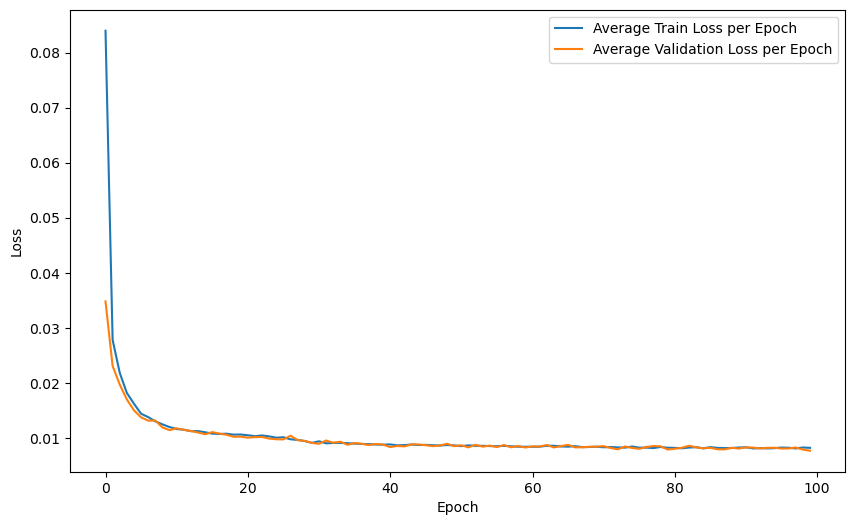

In [13]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_train_losses_per_epoch, label='Average Train Loss per Epoch')
plt.plot(avg_val_losses_per_epoch, label='Average Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
import pandas as pd

# Save losses to CSV
losses = pd.DataFrame({'train_loss': avg_train_losses_per_epoch, 'val_loss': avg_val_losses_per_epoch})

#losses.to_csv('./contents/losses_default_params1.csv', index=False)